# YOLO Step 1 - Preprocessing

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import io
import pandas as pd

In [8]:
# !pip uninstall boto3 # do this in command line
# !pip install boto3==1.19.12


#!conda install boto3=1.18.21
import boto3
print(boto3.__version__)


bucket = 'autoarki-ground-truth-labeling'
client = boto3.client('s3')
response = client.list_objects_v2(Bucket=bucket)


1.19.12


In [9]:
import s3fs
print(s3fs.__version__)

2021.11.1


In [10]:
import botocore
print(botocore.__version__)

1.22.12


## View one of the original raw files

In [11]:
file_name = 'bounding_box/images/0.jpg'
s3_clientobj = client.get_object(Bucket= bucket, Key=file_name)
s3_clientobj

{'ResponseMetadata': {'RequestId': 'FKJDY2685GGHJCVB',
  'HostId': 'IcD8K+n/9T0suI0GnBx8AyDKAWU1VjZRYx3q3A2IIxdWdHP3Wid1je6TWLlzbYplTD4uycrtDDw=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'IcD8K+n/9T0suI0GnBx8AyDKAWU1VjZRYx3q3A2IIxdWdHP3Wid1je6TWLlzbYplTD4uycrtDDw=',
   'x-amz-request-id': 'FKJDY2685GGHJCVB',
   'date': 'Thu, 24 Feb 2022 21:47:48 GMT',
   'last-modified': 'Sat, 19 Feb 2022 00:24:31 GMT',
   'etag': '"5c879dcfb0c70d453e7791c2edc67f29"',
   'accept-ranges': 'bytes',
   'content-type': 'image/jpeg',
   'server': 'AmazonS3',
   'content-length': '83894'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2022, 2, 19, 0, 24, 31, tzinfo=tzutc()),
 'ContentLength': 83894,
 'ETag': '"5c879dcfb0c70d453e7791c2edc67f29"',
 'ContentType': 'image/jpeg',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x7f81dc58b110>}

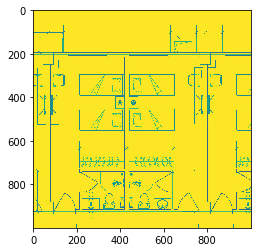

In [12]:
from io import BytesIO
image = mpimg.imread(BytesIO(s3_clientobj['Body'].read()), 'jp2')

plt.figure(0)
plt.imshow(image)


## for each image return the bounding boxes
1. Update input.json 

https://aws.amazon.com/blogs/machine-learning/streamlining-data-labeling-for-yolo-object-detection-in-amazon-sagemaker-ground-truth/

2. Create a csv with each image and annotation

In [57]:
# create and save a csv with all the annotations combined
mani_path = "s3://autoarki-ground-truth-labeling/bounding_box/ground_truth_annots/yolo-bbox-train/manifests/output.manifest"
job_name = 'yolo-bbox-train'

# create df
from  parse_annot import *
df_annot = parse_gt_output(mani_path, job_name)
dest = "bounding_box/ground_truth_annots/yolo-bbox-train"

# save out
df_annot.to_csv(f"s3://{bucket}/{dest}/annot.csv", index = False)



In [63]:
df_annot.head()

,img_file,category,box_left,box_top,box_height,box_width,img_width,img_height
0,100.jpg,overlapping text,463,688,62,44,1000,1000
1,1041.jpg,overlapping text,549,248,42,60,1000,1000
2,1042.jpg,overlapping text,707,659,130,33,1000,1000
3,1047.jpg,overlapping text,476,498,128,31,1000,1000
4,1070.jpg,overlapping text,278,263,27,100,1000,1000


3. Get bounding boxes for each image

In [58]:
# grab csv from S3 into memory
file_key = "annot.csv"
annot_file = 's3://{}/{}/{}'.format(bucket, dest, file_key)


## Preprocess into YOLO format

In [67]:
def annot_yolo(annot_file, cats):
    """
    Prepares the annotation in YOLO format

    Input:
    annot_file: csv file containing Ground Truth annotations
    ordered_cats: List of object categories in proper order for model training

    Returns:
    df_ann: pandas dataframe with the following columns
            img_file int_category box_center_w box_center_h box_width box_height


    Note:
    YOLO data format: <object-class> <x_center> <y_center> <width> <height>
    """

    df_ann = pd.read_csv(annot_file)

    df_ann["int_category"] = df_ann["category"].apply(lambda x: cats.index(x))
    df_ann["box_center_w"] = df_ann["box_left"] + df_ann["box_width"] / 2
    df_ann["box_center_h"] = df_ann["box_top"] + df_ann["box_height"] / 2

    # scale box dimensions by image dimensions
    df_ann["box_center_w"] = df_ann["box_center_w"] / df_ann["img_width"]
    df_ann["box_center_h"] = df_ann["box_center_h"] / df_ann["img_height"]
    df_ann["box_width"] = df_ann["box_width"] / df_ann["img_width"]
    df_ann["box_height"] = df_ann["box_height"] / df_ann["img_height"]

    return df_ann

In [69]:
df_annot = annot_yolo(annot_file, "overlapping text")
df_annot

,img_file,category,box_left,box_top,box_height,box_width,img_width,img_height,int_category,box_center_w,box_center_h
0,100.jpg,overlapping text,463,688,0.062,0.044,1000,1000,0,0.4850,0.7190
1,1041.jpg,overlapping text,549,248,0.042,0.060,1000,1000,0,0.5790,0.2690
2,1042.jpg,overlapping text,707,659,0.130,0.033,1000,1000,0,0.7235,0.7240
3,1047.jpg,overlapping text,476,498,0.128,0.031,1000,1000,0,0.4915,0.5620
4,1070.jpg,overlapping text,278,263,0.027,0.100,1000,1000,0,0.3280,0.2765
...,...,...,...,...,...,...,...,...,...,...,...
244,5668.jpg,overlapping text,660,253,0.077,0.052,1000,1000,0,0.6860,0.2915
245,5668.jpg,overlapping text,722,172,0.077,0.051,1000,1000,0,0.7475,0.2105
246,5679.jpg,overlapping text,8,0,0.136,0.089,1000,1000,0,0.0525,0.0680
247,5679.jpg,overlapping text,125,909,0.091,0.074,1000,1000,0,0.1620,0.9545


In [ ]:
df_ann = annot_rcnn(annot_file, "Overlapping text")
df_ann.head()

In [61]:
def save_annots_to_s3(s3_bucket, prefix, df_local):
    """
    For every image in the dataset, save a text file with annotation in YOLO format

    Input:
    s3_bucket: S3 bucket name
    prefix: Folder name under s3_bucket where files will be written
    df_local: pandas dataframe with the following columns
              img_file int_category box_center_w box_center_h box_width box_height
    """

    unique_images = df_local["img_file"].unique()
    s3_resource = boto3.resource("s3")

    for image_file in unique_images:
        df_single_img_annots = df_local.loc[df_local.img_file == image_file]
        annot_txt_file = image_file.split(".")[0] + ".txt"
        destination = f"{prefix}/{annot_txt_file}"

        csv_buffer = StringIO()
        df_single_img_annots.to_csv(
            csv_buffer,
            index=False,
            header=False,
            sep=" ",
            float_format="%.4f",
            columns=[
                "int_category",
                "box_center_w",
                "box_center_h",
                "box_width",
                "box_height",
            ],
        )
        s3_resource.Object(s3_bucket, destination).put(Body=csv_buffer.getvalue())

In [72]:
save_annots_to_s3(bucket, "bounding_box/ground_truth_annots/yolo-bbox-train/yolo_friendly_format", df_annot)

## View the bounding box on the annotated original image


In [77]:
#Download an image and the corresponding annotation file from Amazon S3. See the following code:

!aws s3 cp s3://autoarki-ground-truth-labeling/bounding_box/ground_truth_annots/yolo-bbox-train/yolo_friendly_format/100.txt .
!aws s3 cp s3://autoarki-ground-truth-labeling/bounding_box/images/100.jpg .

download: s3://autoarki-ground-truth-labeling/bounding_box/images/100.jpg to ./100.jpg


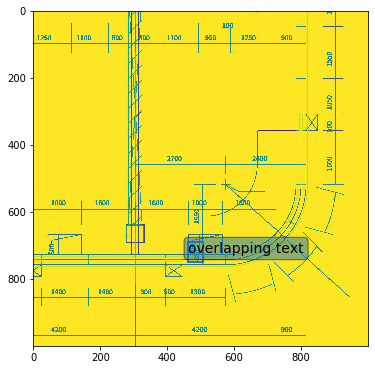

In [101]:
#Plots bounding boxes on images

figure_size=(6, 8)
label_dict = {0: "overlapping text"}
img_file = '100.jpg'
yolo_ann_file = '100.txt'

img = mpimg.imread(img_file)
fig, ax = plt.subplots(1, 1, figsize=figure_size)
ax.imshow(img)

im_height, im_width = img.shape
palette = mcolors.TABLEAU_COLORS
colors = [c for c in palette.keys()]
with open(yolo_ann_file, "r") as fin:
    for line in fin:

        cat, center_w, center_h, width, height = line.split()
        cat = int(cat)
        category_name = label_dict[cat]
        left = (float(center_w) - float(width) / 2) * im_width
        top = (float(center_h) - float(height) / 2) * im_height
        width = float(width) * im_width
        height = float(height) * im_height

        rect = plt.Rectangle(
            (left, top),
            width,
            height,
            fill=False,
            linewidth=2,
            edgecolor=colors[cat],
        )
        ax.add_patch(rect)
        props = dict(boxstyle="round", facecolor=colors[cat], alpha=0.5)
        ax.text(
            left,
            top,
            category_name,
            fontsize=14,
            verticalalignment="top",
            bbox=props,
        ) 
plt.show()